In [54]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [56]:
def load_video(path:str) -> List[float]:

    cap=cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean=tf.math.reduce_mean(frames)
    std =tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [57]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [58]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(
    f"The vocabulary is: {num_to_char.get_vocabulary()}"
    f"(size = {char_to_num.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [59]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [60]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    path_bir = '/content/drive/MyDrive/data'
    video_path = os.path.join(path_bir,'s1',f'{file_name}.mpg')
    alignment_path = os.path.join(path_bir,'alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [61]:
test_path = '/content/drive/MyDrive/data/s1/bbaf5a.mpg'

In [62]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]


'bbaf5a'

In [63]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))


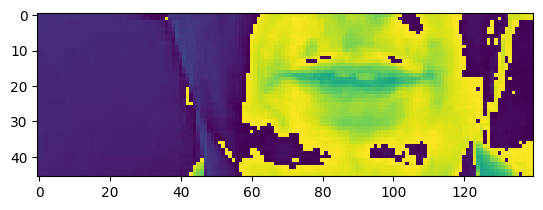

In [64]:
plt.imshow(frames[40])


In [65]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])


<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f five again'>

In [66]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

**Creating Data PipeLine**

In [67]:
from matplotlib import pyplot as plt


In [68]:
data = tf.data.Dataset.list_files('/content/drive/MyDrive/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [69]:
len(test)


50

In [70]:
frames, alignments = data.as_numpy_iterator().next()


In [71]:
len(frames)


2

In [72]:
sample = data.as_numpy_iterator()


In [73]:
val = sample.next(); val[0]


array([[[[[1.3891094 ],
          [1.5017399 ],
          [1.5392833 ],
          ...,
          [0.33789146],
          [0.33789146],
          [0.33789146]],

         [[1.3515658 ],
          [1.5017399 ],
          [1.5392833 ],
          ...,
          [0.33789146],
          [0.33789146],
          [0.33789146]],

         [[1.5017399 ],
          [1.5017399 ],
          [1.4641963 ],
          ...,
          [0.33789146],
          [0.30034795],
          [0.30034795]],

         ...,

         [[1.0136744 ],
          [1.0136744 ],
          [1.0136744 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.0136744 ],
          [1.0136744 ],
          [1.0136744 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.0136744 ],
          [1.0136744 ],
          [1.0136744 ],
          ...,
          [0.        ],
          [0.        ],
          [9.573591  ]]],


        [[[1.3515

In [74]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])


<tf.Tensor: shape=(), dtype=string, numpy=b'set green with x two now'>

**Designing the Network**

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [76]:
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

In [77]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [78]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [79]:
yhat = model.predict(val[0])


1/1 [==============================] - 14s 14s/step


In [80]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])


<tf.Tensor: shape=(), dtype=string, numpy=b"'''''''sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss">

In [81]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])


<tf.Tensor: shape=(), dtype=string, numpy=b"'''''''sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss">

In [82]:
model.input_shape


(None, 75, 46, 140, 1)

In [83]:
model.output_shape


(None, 75, 41)

**Training**

In [84]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [85]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [86]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [87]:
from tensorflow.keras.optimizers import legacy

model.compile(optimizer=legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [88]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)


In [89]:
schedule_callback = LearningRateScheduler(scheduler)


In [90]:
example_callback = ProduceExample(test)


In [91]:
model.load_weights('/content/drive/MyDrive/models/checkpoint')


In [92]:
test_data = test.as_numpy_iterator()


In [93]:
sample = test_data.next()


In [94]:
yhat = model.predict(sample[0])


1/1 [==============================] - 60s 60s/step


In [95]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set blue by a eight now'>]

**Testing On A Video**

In [97]:
sample = load_data(tf.convert_to_tensor('/content/drive/MyDrive//data/s1/bras9a.mpg'))


In [98]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [99]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))


1/1 [==============================] - 8s 8s/step


In [100]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()


In [101]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]